In [637]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.special import erf
from scipy.optimize import minimize
import jax
from jax import grad, jit
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import time
from IPython.display import display, clear_output
from jax.scipy.linalg import cho_solve
from tqdm import trange


## MC Integration

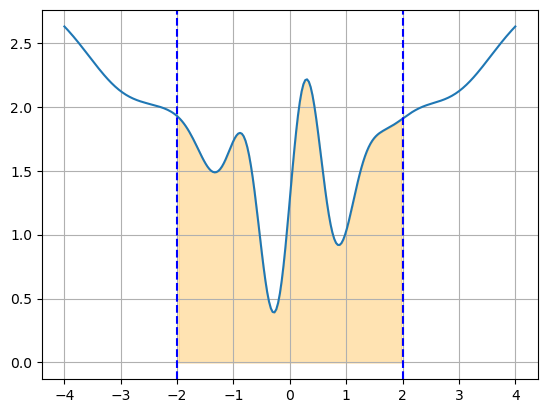

True value: 5.96051236421104

Normal Monte Carlo:
Value: 6.005507, Absolute Error: 0.044994, StDev:0.055698

Monte Carlo with Antithetic Variables:
Value: 5.999249, Absolute Error: 0.038737, StDev:0.026054


In [318]:
def f(x):
    return jnp.exp(-x**2)*jnp.sin(5*x) + jnp.log(1 + x**2)/(1 + x**4) + (x**2 + jnp.cos(3*x) + 1.1)**(1/3)

lower = -2
upper = 2
interval = upper - lower

points = np.linspace(lower-0.5*interval,upper+0.5*interval,250)
y = f(points)

mask = (points >= lower) & (points <= upper)
points_fill = points[mask]
y_fill = y[mask]

plt.plot(points,y)
plt.axvline(lower, color='b', linestyle='--',)
plt.axvline(upper, color='b', linestyle='--',)
plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3) 
plt.grid()
plt.show()

n = 1000
true_value = 5.96051236421104

#Normal MC
x = np.random.uniform(0,1,n)
x1 = lower + x*interval
mc = jnp.mean(f(x1))*interval
error1 = np.abs(true_value - mc)
StDev1 = np.sqrt(np.var(f(x1))/n)*interval

n = 1000
#MC with Antithetic Variables
x = 1 - x
x2 = lower + x*interval
mc_at = (0.5*np.mean(f(x1)) + 0.5*np.mean(f(x2)))*interval
error2 = np.abs(true_value - mc_at)
StDev2 = np.sqrt(np.var(0.5*f(x1) + 0.5*f(x2))/n)*interval

print(f"True value: {true_value}")
print()
print("Normal Monte Carlo:")
print(f"Value: {mc:.6f}, Absolute Error: {error1:.6f}, StDev:{StDev1:.6f}")
print()
print("Monte Carlo with Antithetic Variables:")
print(f"Value: {mc_at:.6f}, Absolute Error: {error2:.6f}, StDev:{StDev2:.6f}")

#### 1D Gaussian Process

 - $\begin{aligned}
\boldsymbol{\mu}_{\mathbf{f}_* | \mathbf{f}} &= \boldsymbol{\mu}_2 + \Sigma_{21} \Sigma_{11}^{-1} (\mathbf{x}_1 - \boldsymbol{\mu}_1)\\ &= K(X_*, X) K(X, X)^{-1} \mathbf{f}.
\end{aligned}$


 - $\begin{aligned}
\Sigma_{\mathbf{f}_* | \mathbf{f}} &= \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}\\ &= K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*).
\end{aligned}$

In [319]:
def gp_predict1d(xs, ys, x_eval, kernel, s=1, l=1):
    xs = xs.reshape(-1,1)
    ys = ys.reshape(-1,1)
    x_eval = x_eval.reshape(-1,1)

    K_xx = kernel(xs, xs, s, l)
    K_xs = kernel(x_eval, xs, s, l)
    K_sx = kernel(xs, x_eval, s, l)
    K_xx_eval = kernel(x_eval, x_eval, s, l)

    L = jnp.linalg.solve(K_xx, ys)
    mu = K_xs@L
    sig = K_xx_eval - K_xs@jnp.linalg.solve(K_xx, K_sx)
    return mu.ravel(), sig + 1e-9*jnp.eye(sig.shape[0])

#Kernel 1
def rbf1d(x1, x2, s=1, l=1):
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(1,-1)
    dists = (x1 - x2)**2/(2*l**2)
    return s**2*jnp.exp(-dists)

#Kernel 2
def matern1d(x1,x2,rho=1/5):
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(1,-1)

    t1 = (1 + jnp.sqrt(3)*jnp.abs(x1-x2)/rho)
    t2 = jnp.exp(-np.sqrt(3)*jnp.abs(x1-x2)/rho)
    return t1*t2


The marginal likelihood for a GP is given by (equation 2.30 of RW)

$$
\log p(\mathbf{y}|X,\theta) = -\frac{1}{2}\mathbf{y}^T(K(X,X)+\sigma_\epsilon^2I)^{-1}\mathbf{y} -\frac{1}{2}\log\:\left|K(X,X)+\sigma_\epsilon^2I\right| - \frac{N}{2}\log 2\pi,
$$

where $\theta = (\sigma^2, l^2)$ are the hyperparameters of the covariance function $k$

In [320]:
#gp log likelihood for 1d
def neg_gp_likelihood(params, xs, ys, kernel, sigma_e=0):
    s, l = params

    n = len(xs)
    K_xx = kernel(xs, xs, s, l) + sigma_e

    Lc = jnp.linalg.cholesky(K_xx)
    alpha = jnp.linalg.solve(Lc.T, jnp.linalg.solve(Lc, ys))

    term1 = -0.5*ys@alpha
    term2 = -jnp.sum(jnp.log(jnp.diag(Lc)))
    term3 = -0.5*n*jnp.log(2*jnp.pi)

    return -(term1 + term2 + term3)


Optimised params: [1.52803538 0.42529843]
Optimised log marginal likelihood: -14.019573824753412


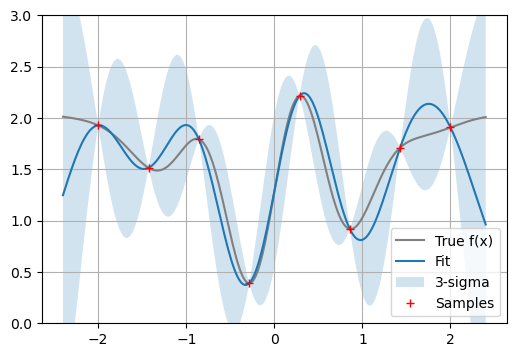

In [321]:
lower = -2
upper = 2
interval = upper - lower

# Sample points for the demonstration
n_total = 8
x_all = jnp.linspace(lower, upper, n_total)
y_all = f(x_all)

x_eval = jnp.linspace(lower-0.1*interval, upper+0.1*interval, 250)

# Start with empty dataset and add points one by one
x_data = jnp.array([])
y_data = jnp.array([])


for i in range(n_total):
    # Add next point
    x_data = jnp.append(x_data, x_all[i])
    y_data = jnp.append(y_data, y_all[i])
    
    # Re-optimize GP hyperparameters
    grad_fn = grad(neg_gp_likelihood)
    init_params = jnp.array([1.0, 1.0])
    
    res = minimize(
        fun=lambda p: float(neg_gp_likelihood(p, x_data, y_data, rbf1d)),
        x0=init_params,
        jac=lambda p: jnp.array(grad_fn(p, x_data, y_data, rbf1d)),
        method="L-BFGS-B",
        bounds=[(1e-3, None), (1e-3, None)]
    )
    
    s, L = res.x
    
    print("Optimised params:", res.x)
    print("Optimised log marginal likelihood:", -res.fun)

    #compute GP posterior
    mu_eval, var_eval = gp_predict1d(x_data, y_data, x_eval, kernel=rbf1d, s=s, l=L)
    sig_diag = jnp.sqrt(jnp.clip(jnp.diag(var_eval), 0.0, None))
    
    #real curve
    plt.figure(figsize=(6,4))
    plt.plot(x_eval, f(x_eval), color='gray', label='True f(x)')

    #fit
    plt.plot(x_eval, mu_eval, label='Fit')
    plt.fill_between(x_eval, mu_eval-2*sig_diag, mu_eval+2*sig_diag, alpha=0.2, label='3-sigma')
    plt.plot(x_data, y_data, '+', color='red', label='Samples')
    
    plt.ylim(0,3)
    plt.grid()
    plt.legend()
    
    display(plt.gcf())
    time.sleep(0.5)
    clear_output(wait=True)
    plt.close()



#### 2D Gaussian Process

In [369]:
def gp_predict_nd(xs, ys, x_eval, kernel, s, L):
    if L.size == xs.shape[1]:
        L = jnp.diag(L)
    x_eval = jnp.atleast_2d(x_eval)
    xs = jnp.atleast_2d(xs)

    ys = ys.reshape(-1,1)

    K = kernel(xs, xs, s, L) + 1e-6*jnp.eye(xs.shape[0])
    K_s = kernel(xs, x_eval, s, L)
    K_ss = kernel(x_eval, x_eval, s, L)

    # Predictive mean
    mu = K_s.T@jnp.linalg.solve(K, ys)

    # Predictive covariance
    v = jnp.linalg.solve(K, K_s)
    sig = K_ss - K_s.T@v

    return mu.ravel(), sig


def rbf_nd(x1, x2, s, L):
    x1 = jnp.atleast_2d(x1)
    x2 = jnp.atleast_2d(x2)
    n1, d = x1.shape
    n2, _ = x2.shape

    # compute pairwise differences
    diff = x1[:, None, :] - x2[None, :, :]

    # apply lengthscale matrix L
    L_chol = jnp.linalg.cholesky(L)
    L_inv = jnp.linalg.inv(L_chol)
    y = diff @ L_inv.T   # shape (n1, n2, d)


    sqdist = jnp.sum(y**2, axis=2)

    return s**2 * jnp.exp(-0.5 * sqdist)


def rbf_nd(x1, x2, s=1, L=jnp.array([[1]])):
    x1 = jnp.atleast_2d(x1)
    x2 = jnp.atleast_2d(x2)
    
    # 1D special case
    if x1.shape[1] == 1:
        x1 = x1.reshape(-1,1)
        x2 = x2.reshape(1,-1)
        dists = (x1 - x2)**2 / (2*L[0,0]**2)
        return s**2 * jnp.exp(-dists)
    
    # general ND case
    n1, d = x1.shape
    n2, _ = x2.shape
    diff = x1[:, None, :] - x2[None, :, :]   # (n1,n2,d)
    L_chol = jnp.linalg.cholesky(L)
    L_inv = jnp.linalg.inv(L_chol)
    y = jnp.einsum("ijd,dk->ijk", diff, L_inv.T)
    sqdist = jnp.sum(y**2, axis=2)
    return s**2 * jnp.exp(-0.5*sqdist)



Relative Humidity is a function of temperature and dew point.

$$
e_s(T) = 6.1121 \, \exp\left(\left(18.678 - \frac{T}{234.5}\right) \cdot \left(\frac{T}{257.14 + T}\right)\right) \\

e = 6.1121 \, \exp\left(\left(18.678 - \frac{T_d}{234.5}\right) \cdot \left(\frac{T_d}{257.14 + T_d}\right)\right) \\
$$
$$
RH = 100 \times \frac{e}{e_s(T)}
$$

In [323]:
def RH(T, Td):
    eT = 6.1121*jnp.exp((18.678 - T/234.5)*(T/(257.14 + T)))
    eTd = 6.1121*jnp.exp((18.678 - Td/234.5)*(Td/(257.14 + Td)))
    return 100*eTd/eT


The marginal likelihood for a GP is given by (equation 2.30 of RW)

$$
\log p(\mathbf{y}|X,\theta) = -\frac{1}{2}\mathbf{y}^T(K(X,X)+\sigma_\epsilon^2I)^{-1}\mathbf{y} -\frac{1}{2}\log\:\left|K(X,X)+\sigma_\epsilon^2I\right| - \frac{N}{2}\log 2\pi,
$$

where $\theta = (\sigma^2, l^2)$ are the hyperparameters of the covariance function $k$

In [324]:
#gp log likelihood for nd
def neg_gp_likelihood(params, xs, ys, kernel, sigma_e=0):
    s = params[0]
    L_flat = params[1:]
    xs = jnp.reshape(xs, (-1, xs.shape[-1] if xs.ndim > 1 else 1))
    L = jnp.diag(L_flat)

    n = xs.shape[0]
    K_xx = kernel(xs, xs, s, L) + (sigma_e + 1e-6)*jnp.eye(n)

    Lc = jnp.linalg.cholesky(K_xx)
    alpha = cho_solve((Lc, True), ys)

    term1 = 0.5*ys@alpha
    term2 = jnp.sum(jnp.log(jnp.diag(Lc)))
    term3 = 0.5*n*jnp.log(2*jnp.pi)

    return term1 + term2 + term3

Optimised params: [147.71655544 427.61672238 509.51552031]
Optimised log marginal likelihood: -73.10382822734447
For Temp: 32.1°C and DewP: 21.2°C
--------------------------------------
Relative humidity1 is: 52.5792%
The gp estimate is: 42.7644%
Error: 9.8148
95% CI: [0.9504%, 84.5783%]



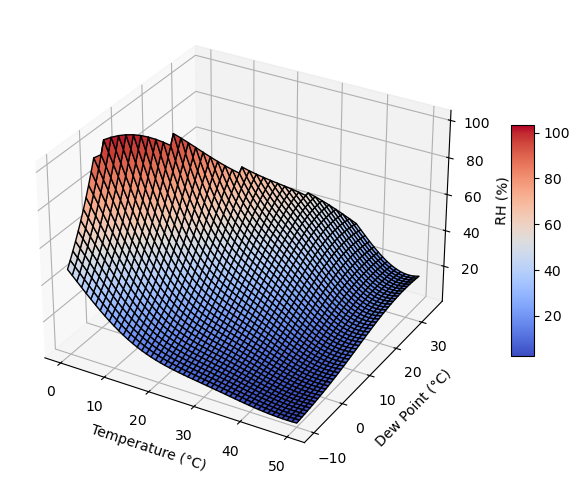

In [370]:
#training data points
Temp = jnp.linspace(0,50,5)
DewP = jnp.linspace(-10,5,4)
T, D = jnp.meshgrid(Temp, DewP)
TD = jnp.column_stack([T.ravel(), D.ravel()])
rh = RH(TD[:,0], TD[:,1])


#evaluation points
Temp_eval = jnp.linspace(0,50,50)
DewP_eval = jnp.linspace(-10,35,50)
T_eval, D_eval = jnp.meshgrid(Temp_eval, DewP_eval)
TD_eval = jnp.column_stack([T_eval.ravel(), D_eval.ravel()])


grad_fn = grad(neg_gp_likelihood)
s_init = 5.0
#diagonal L
l_init = jnp.array([7.0, 7.0])
init_params = jnp.concatenate([jnp.array([s_init]), l_init])

res = minimize(
    fun=lambda p: float(neg_gp_likelihood(p, TD, rh, rbf_nd)),
    x0=init_params,
    jac=lambda p: jnp.array(grad_fn(p, TD, rh, rbf_nd)),
    method="L-BFGS-B",
    bounds=[(1e-3, None)] * len(init_params)
)

print("Optimised params:", res.x)
print("Optimised log marginal likelihood:", -res.fun)



#fit GP
s = res.x[0]
L = jnp.diag(res.x[1:])



mu_grid, var_grid = gp_predict_nd(TD, rh, TD_eval, kernel=rbf_nd, s=s, L=L)
mu_grid = mu_grid.reshape(T_eval.shape)
mu_grid = np.where(D_eval > T_eval, jnp.nan, mu_grid)


#calculate relative humidity at random point
T = np.random.uniform(0,50,1)[0]
D = np.random.uniform(-10,T,1)[0]
td_eval = jnp.array([[T, D]])
relhum = RH(T,D)


#predict at same random point
gp_est, gp_var = gp_predict_nd(TD, rh, td_eval, kernel=rbf_nd, s=s, L=L)
low = gp_est - 1.96*jnp.sqrt(gp_var)
high = gp_est + 1.96*jnp.sqrt(gp_var)
error = np.abs(relhum - gp_est)


print(f'For Temp: {T:.1f}°C and DewP: {D:.1f}°C')
print('--------------------------------------')
print(f'Relative humidity1 is: {relhum:.4f}%')
print(f'The gp estimate is: {gp_est[0]:.4f}%')

print(f'Error: {error[0]:.4f}')
print(f'95% CI: [{low[0][0]:.4f}%, {high[0][0]:.4f}%]')
print()

#plot of GP surface
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T_eval, D_eval, mu_grid, cmap=cm.coolwarm, edgecolor='k')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Dew Point (°C)')
ax.set_zlabel('RH (%)')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


## Bayesian Quadrature
### Integrating f(t)

So we have:
$$
\boxed{v[k] = \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) \, \left[\frac{1}{2} \text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) - \frac{1}{2} \text{erf}\left(\frac{a-s}{\sigma\sqrt{2}} \right) \right]}
$$     

$$
\boxed{vv[k] = \sigma_f^2 \left[ \sigma \sqrt{2\pi} \, (x-a) \, \text{erf} \left( \frac{x-a}{\sigma \sqrt{2}} \right) + 2 \sigma^2 \left( e^{-{\frac{(x-a)^2}{2 \sigma^2}}} - 1 \right) \right]}
$$


$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$


where $$\textbf{k}_F(x) = \Big[ \int_a^x k(t, x_1)dt,\, \int_a^x k(t, x_2)dt,\, \cdots ,\, \int_a^x k(t, x_n)dt \Big]$$,
$$K(x'x) = \int_a^x \int_a^{x'} k(t, s)\,ds\,dt $$

and $K = k(X,X)$ is the Gram matrix of the training inputs under the kernel k.

In [361]:
def vk(input,lower, upper, s=1,L=1):
    t1 = jnp.sqrt(2*jnp.pi)
    t2 = (0.5*erf((upper-input)/(L*jnp.sqrt(2))) - 0.5*erf((lower-input)/(L*jnp.sqrt(2))))
    return s**2*L*t1*t2

def vvk(lower, upper, s=1, L=1):
    t1 = L*jnp.sqrt(2*jnp.pi)*(upper-lower)
    t2 = erf((upper-lower)/(L*jnp.sqrt(2)))
    t3 = jnp.exp(-(upper-lower)**2/(2*L**2)) - 1
    return s**2*(t1*t2 + 2*L**2*t3)

def integrate_rbf1d(x_eval,y_eval, lower, upper, s=1,L=1):
    x_eval = x_eval.reshape(-1,1)
    y_eval = y_eval.reshape(-1,1)
    
    kxx = rbf1d(x_eval,x_eval.T,s,L)
    kxx += 1e-10*jnp.eye(len(kxx))
    kxx = (kxx + kxx.T)/2
    
    kf = vk(x_eval,lower,upper,s,L)

    mu = kf.reshape(1,-1)@jnp.linalg.solve(kxx,y_eval)
    var = vvk(lower,upper,s,L) - kf.reshape(1,-1)@jnp.linalg.solve(kxx,kf.reshape(-1,1))
    var = jnp.maximum(var, 0.0)
    
    return mu, var

Bayesian Quadrature
2 pts:
True value: 5.96051236421104

Optimised params: [1.91787496e+00 1.48937953e+05]
Optimised log marginal likelihood: 0.42653952727427713

Estimate: 7.67138990 , StDev: 0.00190788
Absolute Error: 1.71087753



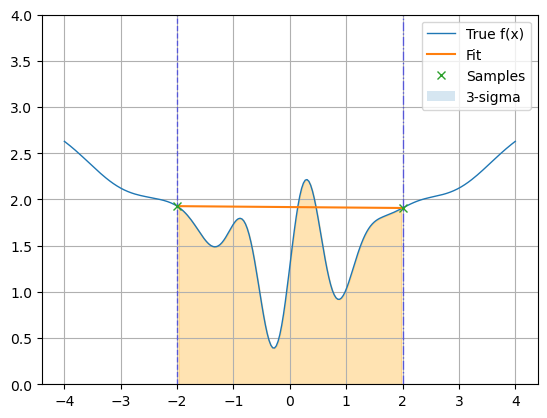

4 pts:
True value: 5.96051236421104

Optimised params: [1.81417399 5.67869442]
Optimised log marginal likelihood: -5.074665594011025

Estimate: 5.97209499 , StDev: 0.00129211
Absolute Error: 0.01158262



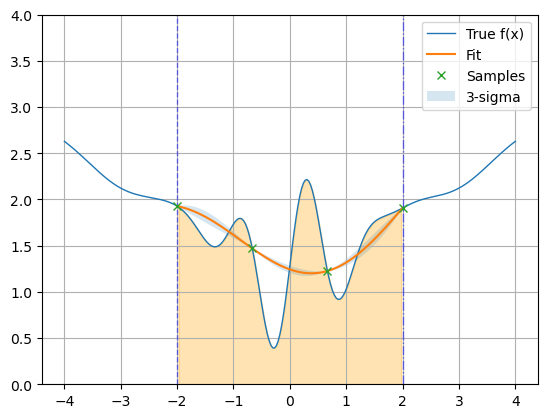

6 pts:
True value: 5.96051236421104

Optimised params: [1.52976358 0.4599502 ]
Optimised log marginal likelihood: -10.194116775735312

Estimate: 6.05735198 , StDev: 0.35308357
Absolute Error: 0.09683962



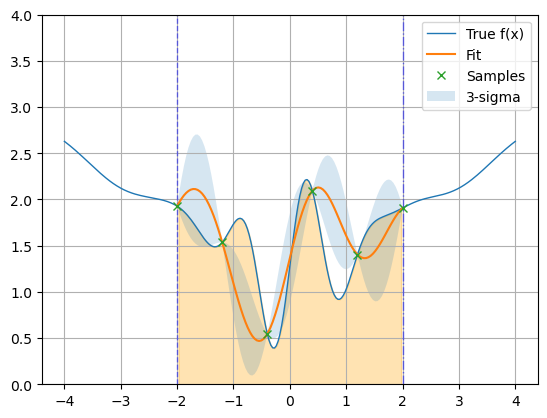

10 pts:
True value: 5.96051236421104

Optimised params: [1.43252442 0.16568646]
Optimised log marginal likelihood: -15.63583418098461

Estimate: 5.30421830 , StDev: 0.66341371
Absolute Error: 0.65629407



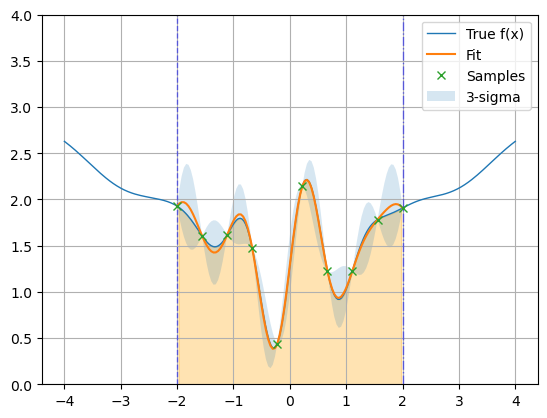

15 pts:
True value: 5.96051236421104

Optimised params: [1.53869975 0.22611305]
Optimised log marginal likelihood: -8.87125083432011

Estimate: 5.99239453 , StDev: 0.05558625
Absolute Error: 0.03188217



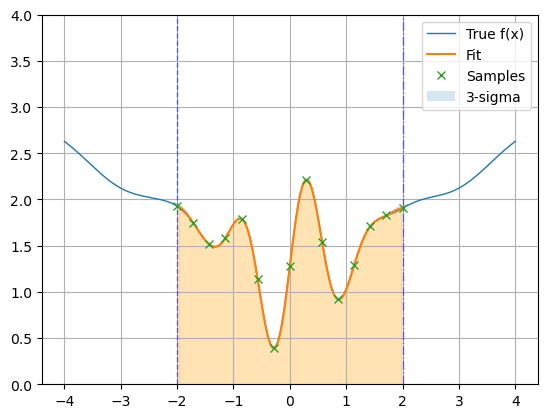

In [363]:
def f(x):
    return jnp.exp(-x**2)*jnp.sin(5*x) + jnp.log(1 + x**2)/(1 + x**4) + (x**2 + jnp.cos(3*x) + 1.1)**(1/3)

lower = -2
upper = 2
interval = upper - lower

points = np.linspace(lower-0.5*interval,upper+0.5*interval,250)
yy = f(points)

mask = (points >= lower) & (points <= upper)
points_fill = points[mask]
y_fill = yy[mask]


true_value = 5.96051236421104

x_eval = np.linspace(lower,upper,100)
print("Bayesian Quadrature")
for n in [2,4,6,10,15]:
    x = jnp.linspace(lower,upper,n)
    y = f(x)


    grad_fn = grad(neg_gp_likelihood)
    s_init = 1
    #diagonal L
    l_init = jnp.array([1])
    init_params = jnp.concatenate([jnp.array([s_init]), l_init])

    res = minimize(
        fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf_nd)),
        x0=init_params,
        jac=lambda p: jnp.array(grad_fn(p, x, y, rbf_nd)),
        method="L-BFGS-B",
        bounds=[(1e-3, None)] * len(init_params)
    )


    plt.plot(points,yy, label='True f(x)', linewidth=1)
    plt.axvline(lower, color='b', linestyle='--',linewidth=1, alpha=0.5)
    plt.axvline(upper, color='b', linestyle='-.',linewidth=1, alpha=0.5)
    plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3) 
    plt.grid()

    #kernel hyperparameters
    s = res.x[0]
    L = jnp.diag(res.x[1:])


    #points to plot gp
    mu_eval,var_eval = gp_predict1d(x,y,x_eval,kernel=rbf_nd,s=s,l=L)
    # sig_diag = np.sqrt(np.clip(np.diag(var_eval), 0.0, None))
    sig_diag = jnp.sqrt(jnp.diag(var_eval))

    I_mu, I_var = integrate_rbf1d(x,y,lower,upper,s,L)
    error = np.abs(true_value - I_mu[0][0])
    print(f"{n} pts:")
    print(f"True value: {true_value}")
    print()
    print("Optimised params:", res.x)
    print("Optimised log marginal likelihood:", -res.fun)
    print()
    print(f"Estimate: {I_mu[0][0]:.8f} , StDev: {np.sqrt(I_var[0][0]):.8f}")
    print(f"Absolute Error: {error:.8f}")
    print()

    
    #plot gp
    plt.plot(x_eval,mu_eval,label='Fit')
    plt.plot(x,y,'x',label='Samples')
    plt.ylim(0,4)
    plt.fill_between(x_eval,mu_eval-2*sig_diag,mu_eval+2*sig_diag,alpha=0.18,label='3-sigma')
    plt.legend()
    plt.show()

## Bayesian Quadrature
### Integrating f(t)p(t) - univariate case

So we have:

$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$

$$
\boxed{v[k] = \sigma_f^2 \sqrt{\frac{l^2}{l^2 + \sigma_p^2}} \; \exp\left[- \frac{(s - \mu_p)^2}{2 (l^2 + \sigma_p^2)} \right]}
$$

$$
\boxed{vv[k] = \sigma_f^2 \sqrt{\frac{l^2}{l^2 + 2 \sigma_p^2}}}
$$



where $$\textbf{k}_F(x) = \Big[ \int k(t, x_1)p(t)dt,\, \int k(t, x_2)p(t)dt,\, \cdots ,\, \int k(t, x_n)p(t)dt \Big]$$,
$$K(x'x) = \int \int k(t, s)p(t)p(s)\,ds\,dt $$

and $K = k(X,X)$ is the Gram matrix of the training inputs under the kernel k.

In [371]:
def vk(input,sigma,L,mu_p,s_p):
    t1 = jnp.sqrt(L**2/(L**2 + s_p**2))
    t2 = jnp.exp(-(input-mu_p)**2/(2*(L**2 + s_p**2)))
    return sigma**2*t1*t2

def vvk(sigma,L,s_q):
    t1 = jnp.sqrt(L**2/(L**2 + 2*s_q**2))
    return sigma**2*jnp.sqrt(L**2/(L**2 + 2*s_q**2))

def integrate_gaussian(x_eval, y_eval, sigma, L, mu_p, s_p):
    x_eval = x_eval.reshape(-1,1)
    y_eval = y_eval.reshape(-1,1)
    
    #kernel matrix
    Kxx = rbf_nd(x_eval, x_eval, s, L)
    Kxx += 1e-10*jnp.eye(len(Kxx))
    
    #cross-covariances
    kF = vk(x_eval, sigma, L, mu_p, s_p).reshape(-1,1)
    vF = vvk(sigma, L, s_p)
    
    #posterior mean and variance
    mu = (kF.T@jnp.linalg.solve(Kxx, y_eval)).item()
    var = vF - (kF.T@jnp.linalg.solve(Kxx, kF)).item()
    var = jnp.maximum(var, 0.0)
    
    return mu, var[0][0]

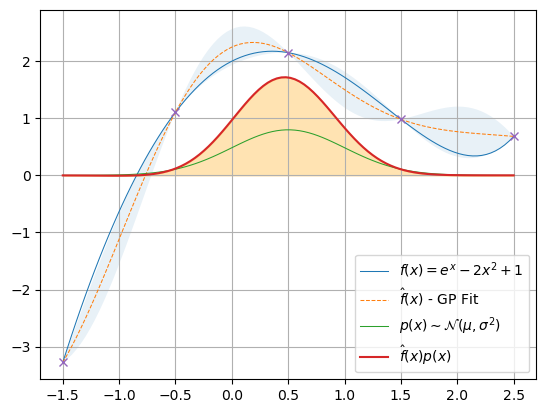

Eₚ[f(x)]: 1.8682459574322223

Bayesian Quadrature
1 pts:
Optimised params: [1.10653015 0.5       ]
Optimised log marginal likelihood: -1.5201681220623735
Estimate: 0.28784187 , StDev: 0.78997467
Absolute Error: 1.58040408

4 pts:
Optimised params: [1.32566629 1.12996312]
Optimised log marginal likelihood: -4.059963713457724
Estimate: 1.87116879 , StDev: 0.00157505
Absolute Error: 0.00292284

8 pts:
Optimised params: [2.8244946  1.40270729]
Optimised log marginal likelihood: 10.054355556565309
Estimate: 1.86820136 , StDev: 0.00006591
Absolute Error: 0.00004460

16 pts:
Optimised params: [3.52479664 1.52500503]
Optimised log marginal likelihood: 55.78181437235306
Estimate: 1.86820909 , StDev: 0.00002788
Absolute Error: 0.00003686

32 pts:
Optimised params: [3.8816996  1.58285823]
Optimised log marginal likelihood: 149.62179042764234
Estimate: 1.86821287 , StDev: 0.00002131
Absolute Error: 0.00003309



In [372]:
def f(x):
    return jnp.exp(x) - 2*x**2 + 1

def fp(x, mu, sigma):
    px = (1/(sigma*jnp.sqrt(2*jnp.pi)))*jnp.exp(-(x-mu)**2/(2*sigma**2))
    return f(x)*px

def FP(mu, sigma):
    t1 = jnp.exp(sigma**2/2 + mu)
    return t1 - 2*sigma**2 - 2*mu**2 + 1

#integral of f(x) from lower to upper
mu = 0.5
sigma = 0.5
true_value = FP(mu,sigma)


#sample n points
n = 5
x = jnp.linspace(mu-4*sigma,mu+4*sigma,n)
y = f(x)

grad_fn = grad(neg_gp_likelihood)
s_init = 1
#diagonal L
l_init = jnp.array([1])
init_params = jnp.concatenate([jnp.array([s_init]), l_init])

res = minimize(
    fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf_nd)),
    x0=init_params,
    jac=lambda p: jnp.array(grad_fn(p, x, y, rbf_nd)),
    method="L-BFGS-B",
    bounds=[(1e-3, None)] * len(init_params)
)

#kernel hyperparameters
s = res.x[0]
L = jnp.diag(res.x[1:])

#points to plot gp
x_eval = np.linspace(mu-4*sigma,mu+4*sigma,100)
mu_eval,var_eval = gp_predict1d(x,y,x_eval,kernel=rbf_nd,s=s,l=L)
sig_diag = np.sqrt(np.clip(np.diag(var_eval), 0.0, None))

#real curve
y1 = f(x_eval)
y2 = (1/(sigma*jnp.sqrt(2*jnp.pi)))*jnp.exp(-(x_eval-mu)**2/(2*sigma**2))
y3 = fp(x_eval,mu,sigma)


mask = (x_eval >= mu-4*sigma) & (x_eval <= mu+4*sigma)
points_fill = x_eval[mask]
y_fill = y3[mask]

#plot gp
plt.plot(x_eval,y1,label=r'$f(x) = e^x - 2x^2 + 1$', ls='-',lw=0.75)
plt.plot(x_eval, mu_eval, label=r'$\hat{f}(x)$ - GP Fit', ls='--', lw=0.75)
plt.plot(x_eval, y2, label=r'$p(x) \sim \mathcal{N}(\mu, \sigma^2)$', ls='-', lw=0.75)
plt.plot(x_eval,y3,label=r'$\hat{f}(x)p(x)$', ls='-')
plt.plot(x,y,'x')
plt.fill_between(x_eval,mu_eval-2*sig_diag,mu_eval+2*sig_diag,alpha=0.1)
plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3) 
plt.legend()
plt.grid()
plt.show()


print(f"Eₚ[f(x)]: {true_value}")
print()
print("Bayesian Quadrature")
for n in [1,4,8,16,32]:

    x = np.linspace(mu-2*sigma,mu+2*sigma,n)
    y = f(x)

    grad_fn = grad(neg_gp_likelihood)
    s_init = 0.5
    #diagonal L
    l_init = jnp.array([0.5])
    init_params = jnp.concatenate([jnp.array([s_init]), l_init])

    res = minimize(
        fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf_nd)),
        x0=init_params,
        jac=lambda p: jnp.array(grad_fn(p, x, y, rbf_nd)),
        method="L-BFGS-B",
        bounds = [(1e-3, None)] * len(init_params)

    )


    #kernel hyperparameters
    s = res.x[0]
    L = jnp.diag(res.x[1:])


    I_mu, I_var = integrate_gaussian(x,y,s,L,mu,sigma)
    error = np.abs(true_value - I_mu)
    print(f"{n} pts:")
    print("Optimised params:", res.x)
    print("Optimised log marginal likelihood:", -res.fun)
    print(f"Estimate: {I_mu:.8f} , StDev: {np.sqrt(I_var):.8f}")
    print(f"Absolute Error: {error:.8f}")
    print()

### Multimodal VBMC

In [666]:
#multimodal gaussian mixture pdf
def mixture_pdf(x, mu_params, s_params, weights=None):
    x = jnp.atleast_1d(x)
    mu_params = jnp.array(mu_params)
    s_params = jnp.array(s_params)

    #assume equal weights
    if weights is None:
        weights = jnp.ones_like(mu_params)/len(mu_params)
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    t1 = 1.0/(jnp.sqrt(2*jnp.pi)*s_params)
    t2 = jnp.exp(-0.5*((x - mu_params)/s_params)**2)
    terms = t1*t2

    return jnp.sum(weights*terms)
def mixture_pdf(x, mu_params, s_params, weights=None):
    x = jnp.atleast_1d(x)
    mu_params = jnp.array(mu_params)
    s_params = jnp.array(s_params)

    n_points = x.shape[0]
    n_components = mu_params.shape[0]

    # default equal weights
    if weights is None:
        weights = jnp.ones(n_components)/n_components
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    t1 = 1.0/(jnp.sqrt(2*jnp.pi)*s_params)
    t2 = jnp.exp(-0.5*((x[:, None] - mu_params[None, :])/s_params[None, :])**2)
    terms = t1[None, :]*t2


    return jnp.sum(weights[None, :]*terms, axis=1)

#MC estimate of entropy of a multimodal gaussian
def entropy(mu_params, s_params, weights=None, n_samples=100,key=None):
    mu_params = jnp.array(mu_params)
    s_params = jnp.array(s_params)
    n_components = len(mu_params)
    key1, key2 = jax.random.split(key)

    #assume equal weights
    if weights is None:
        weights = jnp.ones_like(mu_params)/len(mu_params)
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    #sample from mixture
    mix = jax.random.choice(key1, n_components, shape=(n_samples,), p=weights)
    z = jax.random.normal(key2, shape=(n_samples,))
    samples = mu_params[mix] + s_params[mix]*z

    #compute pdf at sampled points
    pdf_vals = jax.vmap(lambda x: mixture_pdf(x, mu_params, s_params, weights))(samples)

    #return entropy
    h = -jnp.log(pdf_vals + 1e-12)
    return jnp.mean(h)


def log_joint(x_eval, y_eval, sigma, L, mu_params, s_params, weights=None):
    mu_params = jnp.array(mu_params)
    s_params = jnp.array(s_params)
    n_components = len(mu_params)
    
    x_eval = x_eval.reshape(-1, 1)
    y_eval = y_eval.reshape(-1, 1)
    
    #assume equal weights
    if weights is None:
        weights = jnp.ones(n_components)/n_components
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    #kernel matrix
    Kxx = rbf_nd(x_eval, x_eval.T, sigma, L)
    Kxx += 1e-10*jnp.eye(len(Kxx))
    
    #cross-covariances for all components
    kFs = jnp.stack([vk(x_eval, sigma, L, mu_params[i], s_params[i]).reshape(-1, 1)
                    for i in range(n_components)], axis=0)
    kF = jnp.sum(weights[:, None, None]*kFs, axis=0).reshape(-1, 1)
    
    #posterior mean
    mu = kF.T@jnp.linalg.solve(Kxx, y_eval)
    return mu[0, 0]


#ELBO computation for trimodal guassian
def elbo(params, x, y, s=1, L=1, key=None):
    mu_params = params[0]
    s_params = jnp.exp(params[1])

    #compute expected log joint
    expected_log_joint = log_joint(x, y, s, L, mu_params,s_params)

    #entropy of Gaussian q
    entropy_q = entropy(mu_params,s_params, key=key)

    #return negative elbo
    return -expected_log_joint - entropy_q

#in practice we wont know the the value of the parameter/s (obviously) 
# and likelihoods will be difficult or expensive to evaluate
def expensive_log_likelihood(obs, mu_params, s_params, weights=None):
    
    mu_params = jnp.array(mu_params)
    s_params = jnp.array(s_params)
    n_components = len(mu_params)

    #assume equal weights
    if weights is None:
        weights = jnp.ones(n_components)/n_components
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    t1 = 1.0/(jnp.sqrt(2*jnp.pi)*s_params)
    t2 = jnp.exp(-0.5*((obs - mu_params)/s_params)**2)
    terms = t1*t2

    likelihood = jnp.sum(weights*terms, axis=1)
    log_likelihood = jnp.log(likelihood + 1e-12)
    return log_likelihood

#returns new gp points
def active_sample(x, y, proposed_points, mu_true, s_true, mu_params, s_params, n_points=1):
    
    for i in range(n_points):
        grad_fn = grad(neg_gp_likelihood)
        s_init = 10
        l_init = jnp.array([10])
        init_params = jnp.concatenate([jnp.array([s_init]), l_init])

        res = minimize(
            fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf_nd)),
            x0=init_params,
            jac=lambda p: jnp.array(grad_fn(p, x, y, rbf_nd)),
            method="L-BFGS-B",
            bounds=[(1e-4, 12)]*len(init_params)
            )

        #kernel hyperparameters
        s = res.x[0]
        L = jnp.diag(res.x[1:])

        mu, var = gp_predict1d(x, y, proposed_points, kernel=rbf_nd, s=s, l=L)
        var = jnp.diag(var)
        q = mixture_pdf(proposed_points, mu_params, s_params)
        f_exp = jnp.exp(mu)
        
        acquisition_values = var*q*f_exp

        #pick next point
        best_idx = jnp.argmax(acquisition_values)
        x_new = proposed_points[best_idx].reshape(-1,1)
        y_new = expensive_log_likelihood(x_new, mu_true, s_true)
        x = jnp.vstack([x, x_new])
        y = jnp.concatenate([y, y_new])

        sorted_idx = jnp.argsort(x.flatten())
        x = x[sorted_idx]
        y = y[sorted_idx]
        
    return x, y, s, L

Optimised params: [13.21367192 15.        ]
Optimised log marginal likelihood: -19.87930207786954


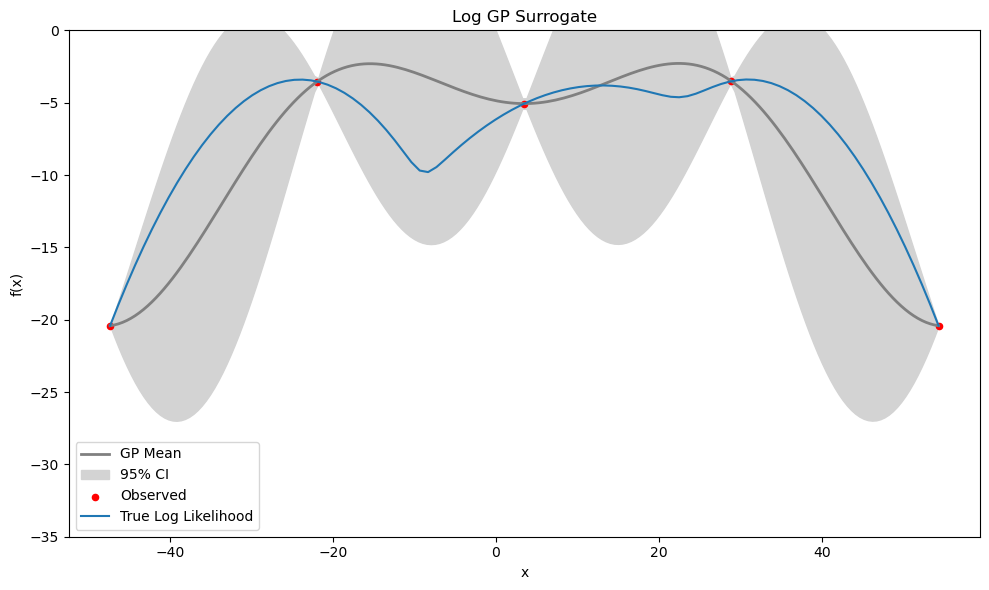

In [665]:
n = 5
mu_true = jnp.array([-24,13,31])
s_true = jnp.array([4,6,4])

lower = min(mu_true) - 5*jnp.mean(s_true)
upper = max(mu_true) + 5*jnp.mean(s_true)


#x = np.random.uniform(lower,upper,n).reshape(-1, 1)
x = jnp.linspace(lower,upper,n).reshape(-1, 1)
y = expensive_log_likelihood(x, mu_true, s_true)

grad_fn = grad(neg_gp_likelihood)
s_init = 5
l_init = jnp.array([10])
init_params = jnp.concatenate([jnp.array([s_init]), l_init])

res = minimize(
    fun=lambda p: float(neg_gp_likelihood(p, x, y, rbf_nd)),
    x0=init_params,
    jac=lambda p: jnp.array(grad_fn(p, x, y, rbf_nd)),
    method="L-BFGS-B",
    bounds=[(1e-2, 15)]*len(init_params)
)

#kernel hyperparameters
s = res.x[0]
L = jnp.diag(res.x[1:])

print("Optimised params:", res.x)
print("Optimised log marginal likelihood:", -res.fun)

x_eval = jnp.linspace(lower,upper,200)
mu_eval,var_eval = gp_predict1d(x,y,x_eval,kernel=rbf_nd,s=s,l=L)
sig_diag = jnp.sqrt(np.diag(var_eval))

#plot gp
plt.figure(figsize=(10, 6))

plt.plot(x_eval, mu_eval, lw=2, color='gray', label='GP Mean')
plt.fill_between(x_eval.ravel(),
                mu_eval.ravel() - 2*sig_diag.ravel(),
                mu_eval.ravel() + 2*sig_diag.ravel(),
                color='lightgray', label='95% CI')


plt.scatter(x, y, c='red', s=20, label='Observed')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Log GP Surrogate")
plt.legend(loc='upper left')
plt.tight_layout()


x_vals = jnp.linspace(lower, upper, 100).reshape(-1,1)
log_likelihood = expensive_log_likelihood(x_vals, mu_true, s_true)

plt.plot(x_vals, log_likelihood, label='True Log Likelihood')
plt.ylim(-35,0)
plt.legend()
plt.show()

### Find variational posterior

$$
\log p(\mathbf{x}) = \underbrace{\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})] - \mathbb{E}_q[\log q(\mathbf{z})]}_{= ELBO} + \underbrace{\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x}))}_{\ge 0}
$$

$$
\text{ELBO} = \underbrace{\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})]}_{=\text{Expected Log Joint}} + \underbrace{\left(-\mathbb{E}_q[\log q(\mathbf{z})]\right)}_{=\text{Entropy of Q}}
$$


 In this example, the expensive likelihood function $p(\mathbf{z}|\mathbf{x}) = p(\mathbf{x},\mathbf{z})$.

 - $\mathbb{E}_q[\log p(\mathbf{z},\mathbf{x})] = \mathbb{E}_q[\log p(\mathbf{z}|\mathbf{x})]$
 - Maximum $\text{ELBO}$ occurs when $\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x})) = 0 \implies q(\mathbf{z}) = p(\mathbf{z}|\mathbf{x})$
 - This makes $\mathbb{E}_q[\log p(\mathbf{z}|\mathbf{x})]$ the negative entropy of Q.
 - This makes the maximum $\text{ELBO} = 0$ 


 Another way to see this is since $p(\mathbf{x},\mathbf{z}) = p(\mathbf{z}|\mathbf{x})p(\mathbf{x})$
 - Maximum $\text{ELBO}$ occurs when $\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x})) = 0$ 
 - $\implies \log p(\mathbf{x}) = \text{ELBO} + \underbrace{\text{KL}(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x}))}_{= 0} = 0$ since $p(\mathbf{x}) = 1$   


Outer loop 1:  24%|██▍       | 6027/25000 [00:01<00:02, 7278.98it/s]

Iter 1, 5000: ELBO = 0.2025111843984111


Outer loop 1:  46%|████▌     | 11460/25000 [00:02<00:01, 9906.00it/s]

Iter 1, 10000: ELBO = 0.268047154148098


Outer loop 1:  68%|██████▊   | 17028/25000 [00:02<00:00, 10462.81it/s]

Iter 1, 15000: ELBO = 0.37202713532697773


Outer loop 1:  86%|████████▌ | 21553/25000 [00:03<00:00, 10911.20it/s]

Iter 1, 20000: ELBO = 0.2196358595564778


Iter 1, 25000: ELBO = 0.4335839065457976


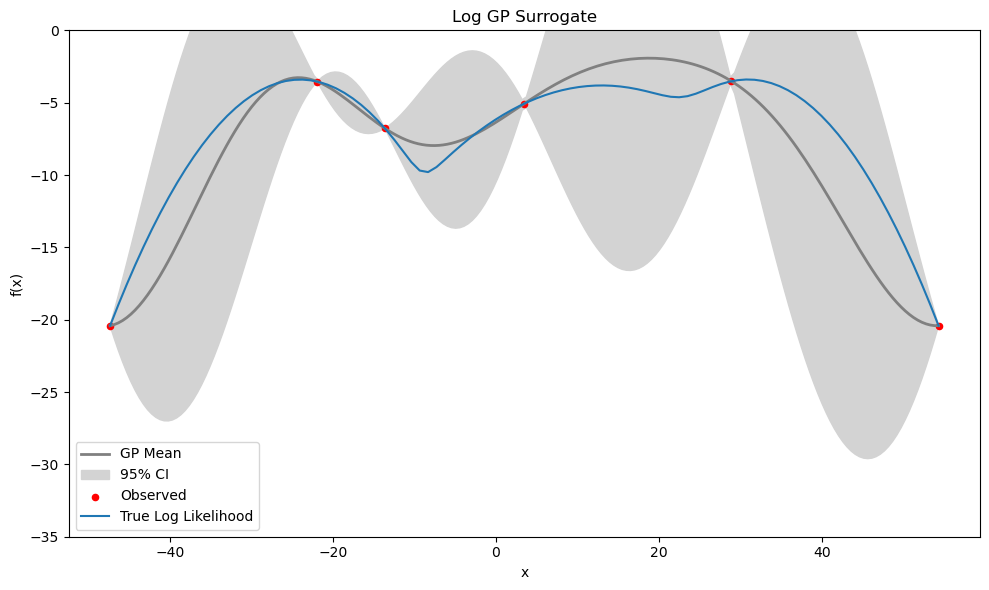

Outer loop 2:  28%|██▊       | 7120/25000 [00:01<00:01, 9515.93it/s]

Iter 2, 5000: ELBO = -1.3526205908309192


Outer loop 2:  47%|████▋     | 11719/25000 [00:01<00:01, 10383.26it/s]

Iter 2, 10000: ELBO = -1.2784435701613672


Outer loop 2:  66%|██████▌   | 16510/25000 [00:02<00:00, 11506.46it/s]

Iter 2, 15000: ELBO = -1.1725835642001918


Outer loop 2:  86%|████████▋ | 21618/25000 [00:02<00:00, 11981.73it/s]

Iter 2, 20000: ELBO = -1.3295873744090958


Iter 2, 25000: ELBO = -1.2847162824103986


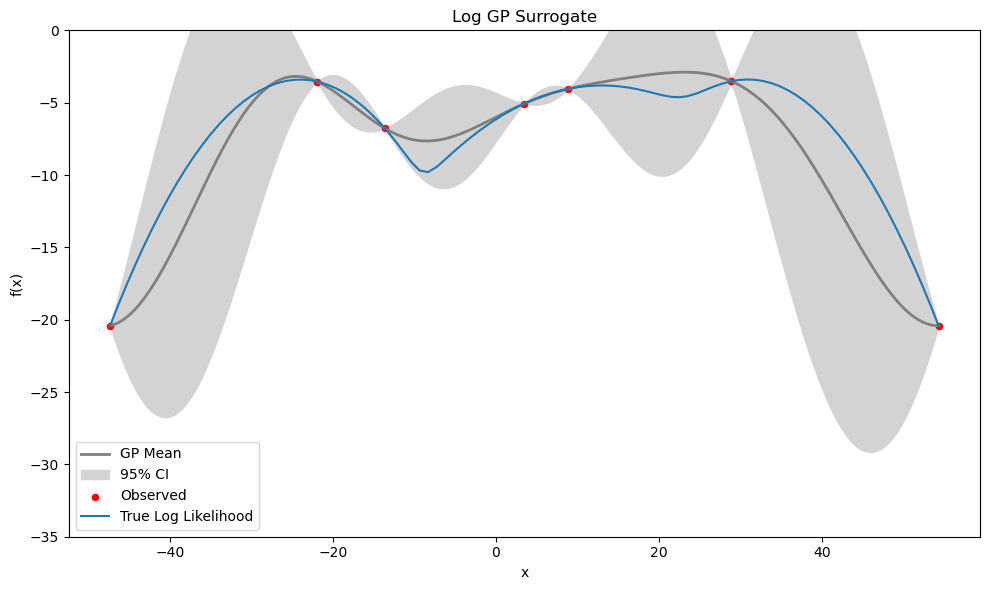

Outer loop 3:  28%|██▊       | 7040/25000 [00:03<00:03, 5665.60it/s]

Iter 3, 5000: ELBO = -1.3340814131726324


Outer loop 3:  47%|████▋     | 11829/25000 [00:03<00:01, 9605.83it/s]

Iter 3, 10000: ELBO = -1.4366419388162406


Outer loop 3:  66%|██████▌   | 16518/25000 [00:04<00:00, 10765.71it/s]

Iter 3, 15000: ELBO = -1.1548871300462489


Outer loop 3:  85%|████████▌ | 21287/25000 [00:04<00:00, 11108.04it/s]

Iter 3, 20000: ELBO = -1.2558646519491132


Iter 3, 25000: ELBO = -1.4317927361361509


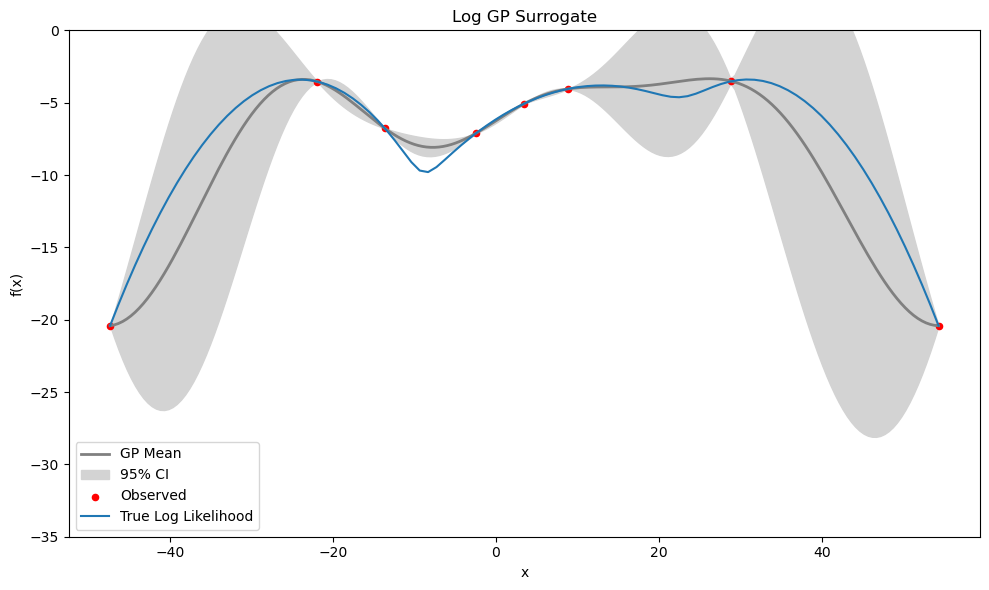

Outer loop 4:  27%|██▋       | 6839/25000 [00:01<00:02, 8543.12it/s]

Iter 4, 5000: ELBO = -1.5303456370703747


Outer loop 4:  45%|████▌     | 11371/25000 [00:01<00:01, 10310.88it/s]

Iter 4, 10000: ELBO = -1.2793568590652962


Outer loop 4:  68%|██████▊   | 16957/25000 [00:02<00:00, 10567.08it/s]

Iter 4, 15000: ELBO = -1.3753459961803642


Outer loop 4:  86%|████████▌ | 21484/25000 [00:02<00:00, 10411.41it/s]

Iter 4, 20000: ELBO = -1.4206144189596595


Iter 4, 25000: ELBO = -1.3689566251544445


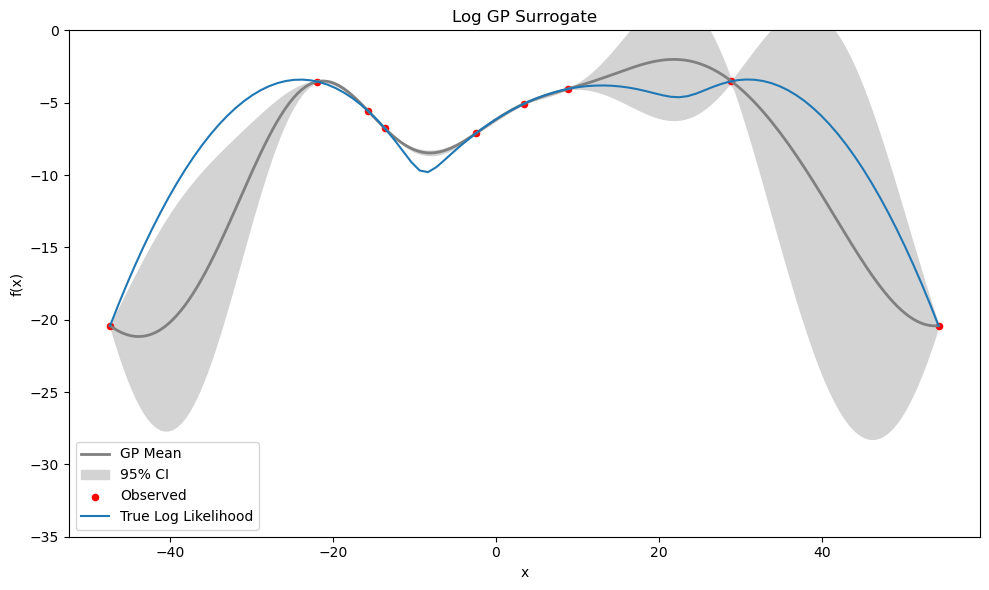

Outer loop 5:  24%|██▍       | 6059/25000 [00:01<00:02, 8261.89it/s]

Iter 5, 5000: ELBO = -1.2587609632617287


Outer loop 5:  47%|████▋     | 11812/25000 [00:01<00:01, 10987.99it/s]

Iter 5, 10000: ELBO = -1.2134863707990307


Outer loop 5:  68%|██████▊   | 16955/25000 [00:02<00:00, 11828.26it/s]

Iter 5, 15000: ELBO = -1.0454917268889914


Outer loop 5:  87%|████████▋ | 21779/25000 [00:02<00:00, 11691.56it/s]

Iter 5, 20000: ELBO = -0.8576155256171099


Iter 5, 25000: ELBO = -0.9482842157741525


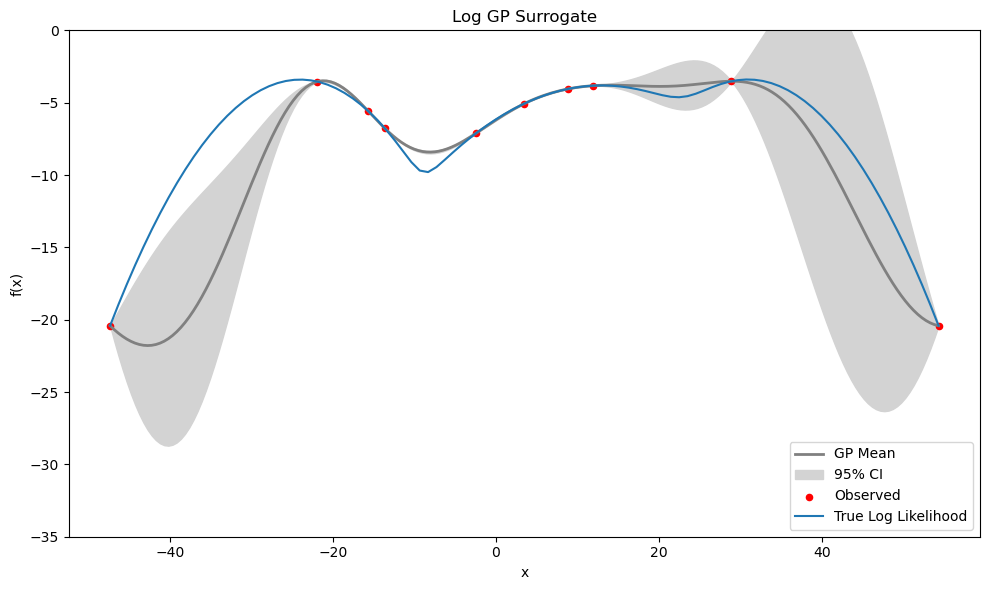

Outer loop 6:  27%|██▋       | 6694/25000 [00:01<00:02, 7871.40it/s]

Iter 6, 5000: ELBO = -1.0116189489731804


Outer loop 6:  46%|████▌     | 11434/25000 [00:01<00:01, 8819.19it/s]

Iter 6, 10000: ELBO = -0.9407289825237761


Outer loop 6:  63%|██████▎   | 15709/25000 [00:02<00:01, 6567.41it/s]

Iter 6, 15000: ELBO = -0.844946440666416


Outer loop 6:  85%|████████▌ | 21355/25000 [00:03<00:00, 6808.57it/s]

Iter 6, 20000: ELBO = -0.8787223773041992


Iter 6, 25000: ELBO = -0.8104924180358739


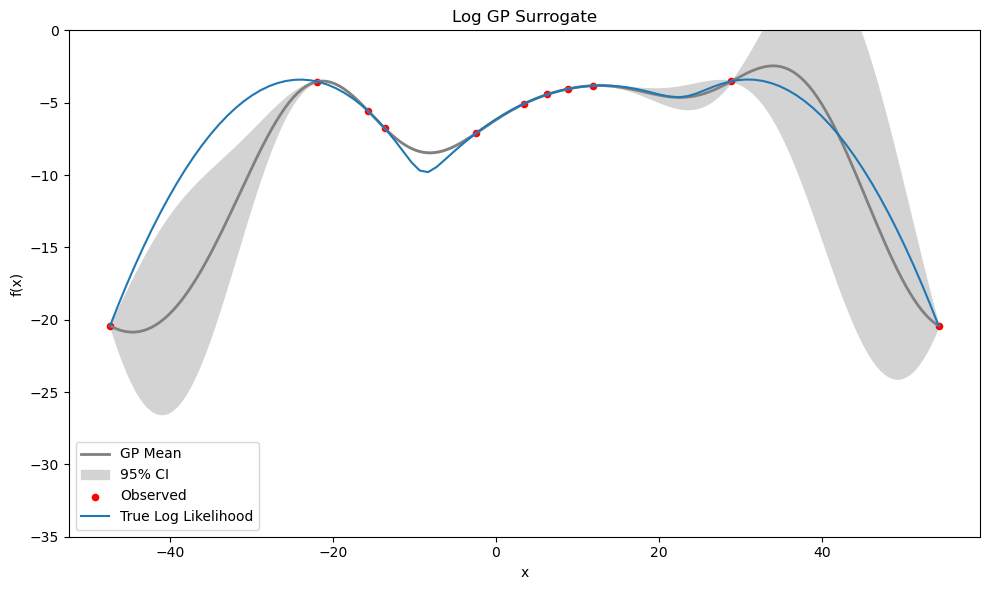

Outer loop 7:  25%|██▍       | 6242/25000 [00:01<00:03, 6200.76it/s]

Iter 7, 5000: ELBO = -1.0021496565894323


Outer loop 7:  43%|████▎     | 10684/25000 [00:02<00:02, 5362.73it/s]

Iter 7, 10000: ELBO = -0.828345602389915


Outer loop 7:  64%|██████▍   | 16038/25000 [00:03<00:01, 5200.88it/s]

Iter 7, 15000: ELBO = -0.743829149683906


Outer loop 7:  84%|████████▍ | 20939/25000 [00:04<00:00, 5245.17it/s]

Iter 7, 20000: ELBO = -0.7844762837675718


Iter 7, 25000: ELBO = -0.7083299254180124


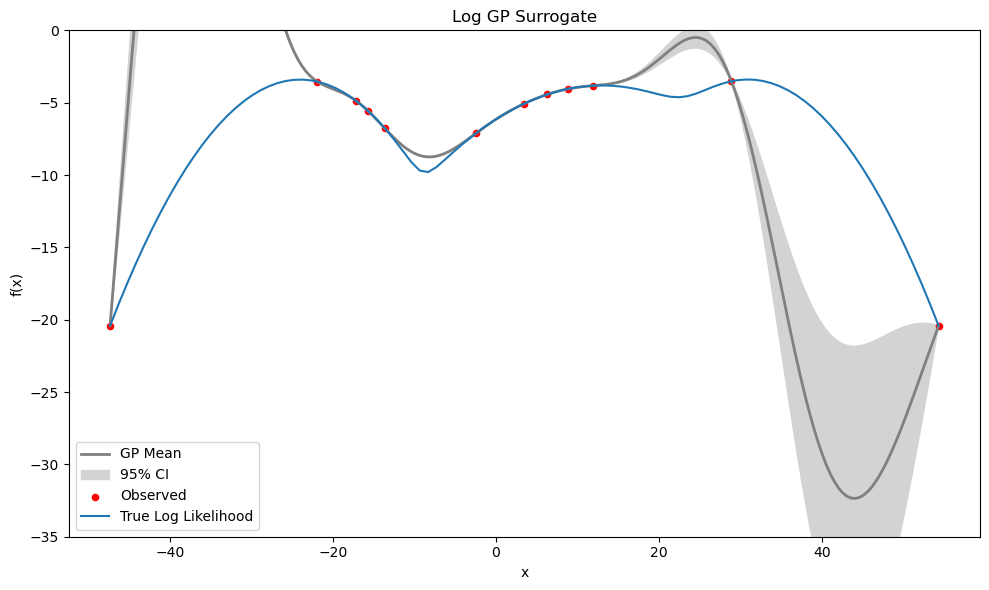

Outer loop 8:  23%|██▎       | 5764/25000 [00:02<00:03, 4866.99it/s]

Iter 8, 5000: ELBO = 1.8339003942068346


Outer loop 8:  43%|████▎     | 10833/25000 [00:03<00:03, 4402.93it/s]

Iter 8, 10000: ELBO = 2.218905881922096


Outer loop 8:  63%|██████▎   | 15774/25000 [00:04<00:01, 5524.01it/s]

Iter 8, 15000: ELBO = 2.7737333444658705


Outer loop 8:  88%|████████▊ | 21918/25000 [00:05<00:00, 9775.44it/s]

Iter 8, 20000: ELBO = 3.7071916331974624


Iter 8, 25000: ELBO = 4.885873520751749


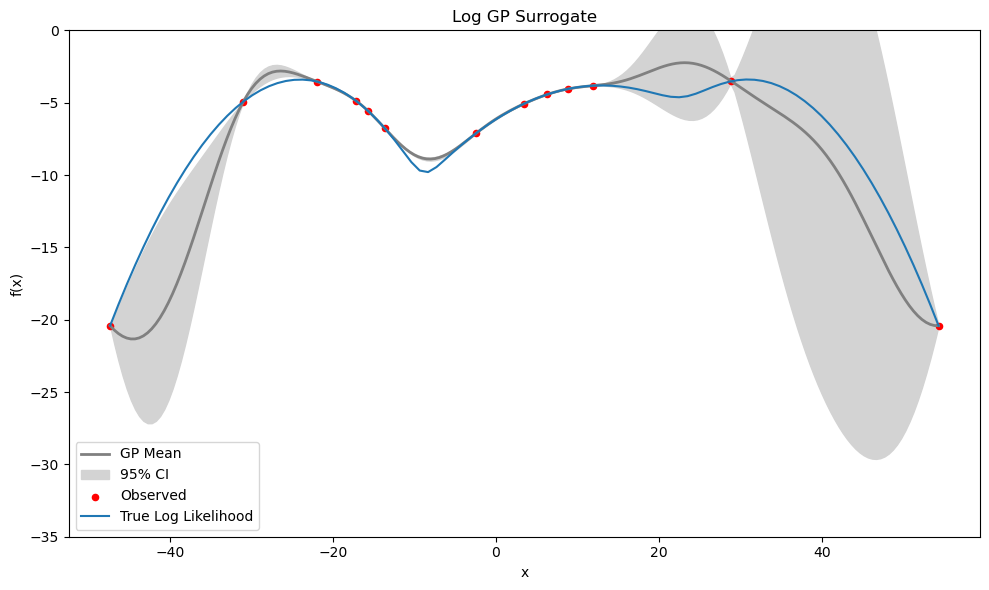

Outer loop 9:  26%|██▋       | 6572/25000 [00:01<00:02, 7223.15it/s]

Iter 9, 5000: ELBO = -0.5363842428945849


Outer loop 9:  44%|████▍     | 11025/25000 [00:02<00:01, 8467.45it/s]

Iter 9, 10000: ELBO = -0.3545072027124485


Outer loop 9:  64%|██████▎   | 15890/25000 [00:02<00:01, 9069.66it/s]

Iter 9, 15000: ELBO = -0.21464795691437555


Outer loop 9:  86%|████████▌ | 21387/25000 [00:03<00:00, 7695.45it/s]

Iter 9, 20000: ELBO = -0.13442804495024774


Iter 9, 25000: ELBO = -0.27171346467103197


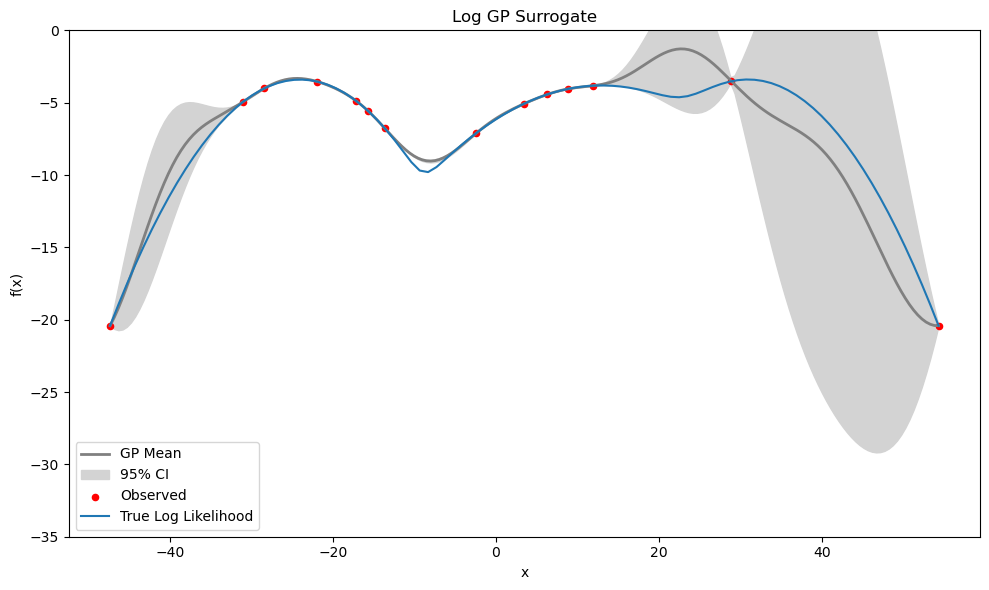

Outer loop 10:  24%|██▍       | 6004/25000 [00:01<00:03, 6228.38it/s]

Iter 10, 5000: ELBO = -0.19012037199521004


Outer loop 10:  43%|████▎     | 10723/25000 [00:02<00:02, 6999.39it/s]

Iter 10, 10000: ELBO = 0.03318475699400736


Outer loop 10:  64%|██████▍   | 16003/25000 [00:03<00:01, 7169.40it/s]

Iter 10, 15000: ELBO = -0.19330425267373919


Outer loop 10:  83%|████████▎ | 20723/25000 [00:03<00:00, 7344.63it/s]

Iter 10, 20000: ELBO = -0.08451407906093955


Iter 10, 25000: ELBO = -0.011631575710605802


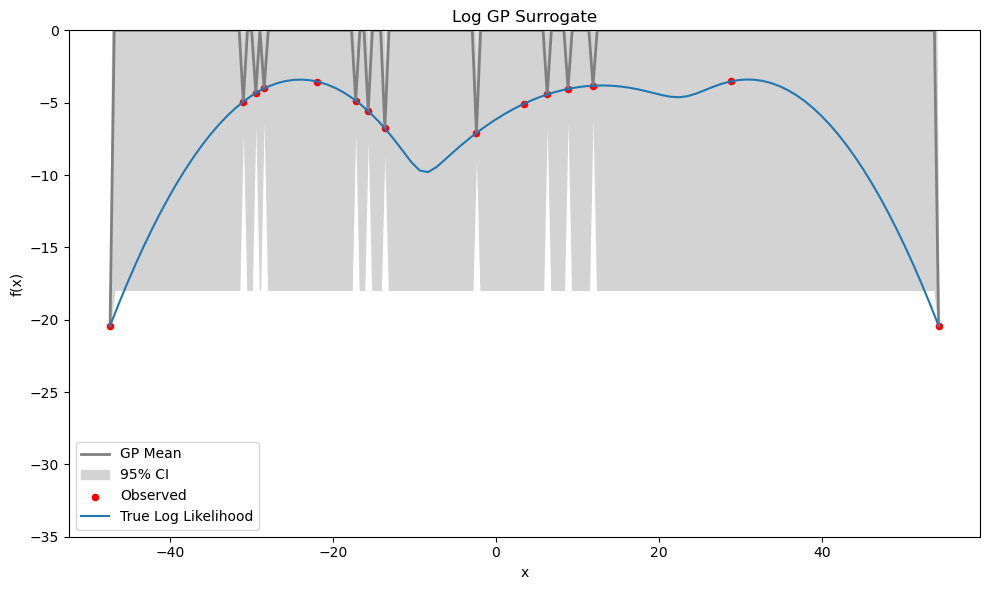


Best ELBO 4.885873520751749
Parameter     Optimized         True
------------------------------------
mu1            -29.5419     -24.0000
mu2             -0.0299      13.0000
mu3             12.1031      31.0000
sigma1           5.1530       4.0000
sigma2          19.5532       6.0000
sigma3           7.0247       4.0000


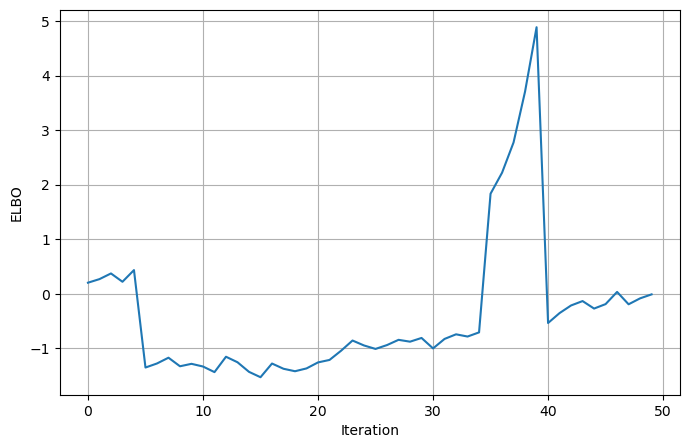

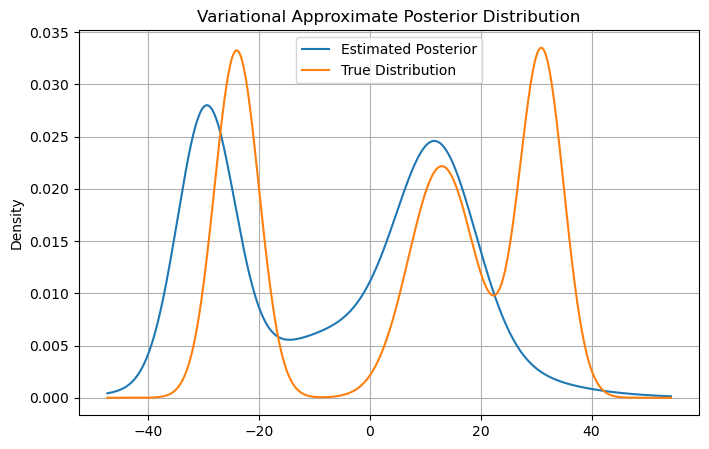


Time taken: 43.38 seconds


In [667]:
#initial values
mu_initial = jnp.array([-13,-3,4])
s_initial = jnp.array([6,9,2])
params = jnp.array([mu_initial, jnp.log(s_initial)])
x_eval = jnp.linspace(lower,upper,200)

grad_elbo = jit(grad(elbo))

best_elbo = -jnp.inf
best_params = params.copy()

key = jax.random.PRNGKey(0)
lr = 0.001
elbo_history = []
start = time.time()
x_active = x
y_active = y

for j in range(10):
    for i in trange(25_000, desc=f"Outer loop {j+1}", leave=False):
        key, subkey = jax.random.split(key)
        grads = grad_elbo(params, x_active, y_active, s, L, key=key)
        params = params - lr * grads

        if (j*10_000 + (i+1)) % 5_000 == 0:
            current_elbo = -elbo(params, x_active, y_active, s, L, key=key)
            elbo_history.append(current_elbo)
            if current_elbo > best_elbo:
                best_elbo = current_elbo
                best_params = params.copy()
            print(f"Iter {j+1}, {i+1}: ELBO = {current_elbo}")



    x_active, y_active, s, L = active_sample(x_active, y_active, 
                                       x_eval, mu_true, s_true, 
                                       best_params[0], best_params[1], n_points=1)

    mu_eval,var_eval = gp_predict1d(x_active,y_active,x_eval,kernel=rbf_nd,s=s,l=L)
    sig_diag = jnp.sqrt(np.diag(var_eval))

    #plot gp
    plt.figure(figsize=(10, 6))

    plt.plot(x_eval, mu_eval, lw=2, color='gray', label='GP Mean')
    plt.fill_between(x_eval.ravel(),
                    mu_eval.ravel() - 2*sig_diag.ravel(),
                    mu_eval.ravel() + 2*sig_diag.ravel(),
                    color='lightgray', label='95% CI')


    plt.scatter(x_active, y_active, c='red', s=20, label='Observed')
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Log GP Surrogate")
    plt.legend(loc='upper left')
    plt.tight_layout()

    plt.plot(x_vals, log_likelihood, label='True Log Likelihood')
    plt.ylim(-35,0)
    plt.legend()
    plt.show()

params = best_params
n_components = len(mu_initial)
mu_opt = params[0]
s_opt = jnp.exp(params[1]) 

# Create names dynamically
param_names = [f"mu{i+1}" for i in range(n_components)] + \
              [f"sigma{i+1}" for i in range(n_components)]

# Combine optimized and true values
optimized_vals = jnp.concatenate([mu_opt, s_opt]).flatten()
true_vals = jnp.concatenate([jnp.array(mu_true), jnp.array(s_true)]).flatten()

# Print results neatly
print()
print("Best ELBO", best_elbo)
print(f"{'Parameter':<10} {'Optimized':>12} {'True':>12}")
print("-"*36)
for name, opt, true in zip(param_names, optimized_vals, true_vals):
    print(f"{name:<10} {float(opt):12.4f} {float(true):12.4f}")

# Plot ELBO history
plt.figure(figsize=(8,5))
# iterations = jnp.linspace(0,len(elbo_history),len(elbo_history))
plt.plot(elbo_history)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()


#plot range
x_min = lower
x_max = upper
x_vals = jnp.linspace(x_min, x_max, 1000).reshape(-1,1)

#estimated mixture PDF
pdf_vals = jax.vmap(lambda x: mixture_pdf(x, mu_params=mu_opt, s_params=s_opt))(x_vals)

#true pdf
true_vals = jnp.exp(expensive_log_likelihood(x_vals, mu_true, s_true))

#compare estimated and true distributions
plt.figure(figsize=(8,5))
plt.plot(x_vals, pdf_vals, label='Estimated Posterior')
plt.plot(x_vals, true_vals, label='True Distribution')
plt.title('Variational Approximate Posterior Distribution')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


end = time.time()
print()
print(f"Time taken: {end - start:.2f} seconds")



## Bayesian Quadrature
### Integrating f(t)p(t) - multivariate case

So we have:

$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$

$$
\boxed{v[k] = \sigma_f^2 |\mathbf{L}| |\Sigma_p + \mathbf{L^2}|^{-1/2} \exp\Big[-\frac{1}{2} (\mathbf{s}-\boldsymbol{\mu}_p)^T (\Sigma_p +  \mathbf{L^2})^{-1} (\mathbf{s}-\boldsymbol{\mu}_p) \Big]}
$$

$$
\boxed{vv[k] = \sigma_f^2 |\mathbf{L}| \, |2\Sigma_p + \mathbf{L^2}|^{-1/2}}
$$

where $$\textbf{k}_F(x) = \Big[ \int k(\boldsymbol{t}, x_1)p(\boldsymbol{t})d\boldsymbol{t},\, \int k(\boldsymbol{t}, x_2)p(\boldsymbol{t})d\boldsymbol{t},\, \cdots ,\, \int k(\boldsymbol{t}, x_n)p(\boldsymbol{t})d\boldsymbol{t} \Big]$$,
$$K(x'x) = \int \int k(\boldsymbol{t}, \boldsymbol{s})p(\boldsymbol{t})p(\boldsymbol{s})\,d\boldsymbol{s}\,d\boldsymbol{t} $$

and $K = k(X,X)$ is the Gram matrix of the training inputs under the kernel k.

In [18]:
def vk(input, sigmaf, L, mu_p, S_p):
    S_p = jnp.array(S_p)
    L = jnp.atleast_2d(jnp.array(L)) 
    input = jnp.atleast_2d(input).T
    mu_p = jnp.atleast_2d(mu_p).T

    L2 = L@L.T
    t1 = jnp.linalg.det(S_p + L2)
    t1 = jnp.linalg.det(L)/jnp.sqrt(t1)

    inv_term = jnp.linalg.inv(S_p + L2)
    diff = input - mu_p
    t2 = jnp.exp(-0.5*diff.T@inv_term@diff)

    return sigmaf**2*t1*t2

def vvk(sigmaf, L, S_p):
    S_p = jnp.array(S_p)
    L = jnp.atleast_2d(jnp.array(L)) 
    L2 = L@L.T
    det_term = jnp.linalg.det(2*S_p + L2)
    t1 = jnp.linalg.det(L)/jnp.sqrt(det_term)
    return sigmaf**2*t1


def rbf_nd(X1, X2, s, L):
    X1 = jnp.atleast_2d(X1)
    X2 = jnp.atleast_2d(X2)
    L = jnp.atleast_2d(jnp.array(L))
    L = L@L.T

    n1, d = X1.shape
    n2 = X2.shape[0]

    L_chol = jnp.linalg.cholesky(L)

    diff = X1[:, None, :] - X2[None, :, :]
    diff_flat = diff.reshape(-1, d).T

    y = jnp.linalg.solve(L_chol, diff_flat)
    sqdist = jnp.sum(y**2, axis=0).reshape(n1, n2)

    return s**2*jnp.exp(-0.5*sqdist)

def integrate_gaussian(x_eval, y_eval, sigmaf, L, mu_p, S_p):
    x_eval = jnp.atleast_2d(x_eval).astype(jnp.float64)
    y_eval = jnp.atleast_2d(y_eval).astype(jnp.float64)
    n, _ = x_eval.shape

    # Kernel matrix
    Kxx = rbf_nd(x_eval, x_eval, sigmaf, L)
    Kxx += 1e-10*jnp.eye(n)

    # Cross-covariances with Gaussian measure
    kF = jnp.array([vk(x_eval[i], sigmaf, L, mu_p, S_p) for i in range(n)]).reshape(-1,1)

    # Variance of the integral
    vF = vvk(sigmaf, L, S_p)

    # Posterior mean and variance of the integral
    mu = float((kF.T@jnp.linalg.solve(Kxx, y_eval)).item())
    var = float(jnp.maximum(vF - (kF.T@jnp.linalg.solve(Kxx, kF)).item(), 0.0))

    return mu, var




E[x^2 + y^2]
Bivariate normal with mean: [3, -2] and cov: [[2, -1], [-1, 2]]

MC estimate: 17.000518508006472
MC stdev: 0.009268623618904001
GP estimate: 16.996553402798256
GP stdev: 0.00039969742406521574


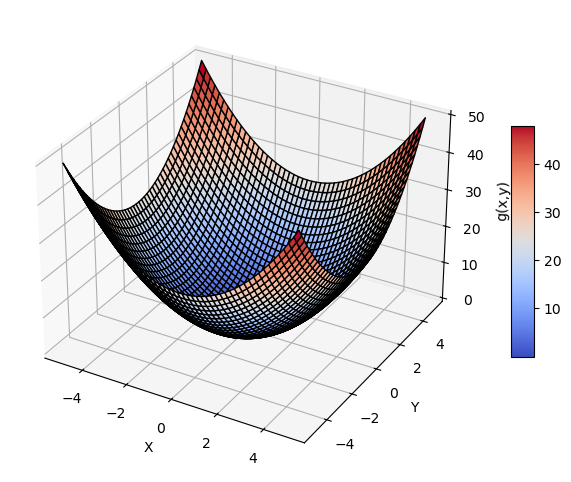

In [ ]:

def mc_nd(func, mean, cov, n=100_000):
    samples = np.random.multivariate_normal(mean, cov, size=n)
    values = func(*samples.T)
    
    mean_est = np.mean(values)
    se_est = np.std(values, ddof=1) / np.sqrt(n)
    
    return mean_est, se_est


# Example function g(x,y)
def g(x, y):
    return x**2 + y**2

mean = [3, -2]
cov = [[2, -1],
       [-1, 2]]

ev = mc_nd(g, mean, cov, n=2000000)
print('E[x^2 + y^2]')
print(f"Bivariate normal with mean: {mean} and cov: {cov}")
print()

print("MC estimate:", ev[0])
print("MC stdev:", ev[1])


#training data
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)
x, Y = np.meshgrid(x, y)
xy = np.column_stack([x.ravel(), Y.ravel()])
gxy1 = g(xy[:, 0], xy[:, 1]).reshape(-1,1)

mu_p = jnp.array(mean)
S_p = jnp.array(cov)

#kernel hyperparameters
s = 20
L = [[5,0],[0,5]]

#compute integral
mu_int, var_int = integrate_gaussian(xy, gxy1, s, L, mean, cov)
print("GP estimate:", mu_int)
print("GP stdev:", jnp.sqrt(var_int))


#evaluation points
x_eval = np.linspace(-5, 5, 50)
y_eval = np.linspace(-5, 5, 50)
X_eval, Y_eval = np.meshgrid(x_eval, y_eval)
xy_eval = np.column_stack([X_eval.ravel(), Y_eval.ravel()])
mu_grid, var_grid = gp_predict_nd(xy, gxy1, xy_eval, kernel=rbf_nd, s=s, L=L)
mu_grid = mu_grid.reshape(X_eval.shape)

#plot GP surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_eval, Y_eval, mu_grid, cmap=cm.coolwarm, edgecolor='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('g(x,y)')
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


In [ ]:
def g3(x, y, z):
    return x**2 + y**2 + z**2

mean = [3, -2, 1]
cov = [[2, -1, 1], [-1, 3, 1], [1, 1, 2]]

ev = mc_nd(g3, mean, cov, n=2000000)
print('E[x^2 + y^2 + z^2]')
print(f"Normal with mean: {mean} and cov: {cov}")
print()

print("MC estimate:", ev[0])
print("MC stdev:", ev[1])


# Example: 3D data
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)
z = np.linspace(-5, 5, 10)
x, Y, Z = np.meshgrid(x, y, z)
xyz = np.column_stack([x.ravel(), Y.ravel(), Z.ravel()])
gxyz = g3(*xyz.T).reshape(-1, 1)

L = [[5, 0, 0], [0, 5, 0], [0, 0, 5]]

mu_int, var_int = integrate_gaussian(xyz, gxyz, s, L, mean, cov)
print("GP estimate:", mu_int)
print("GP stdev:", jnp.sqrt(var_int))

E[x^2 + y^2 + z^2]
Normal with mean: [3, -2, 1] and cov: [[2, -1, 1], [-1, 3, 1], [1, 1, 2]]

MC estimate: 20.998956439739818
MC stdev: 0.010729928098095589
GP estimate: 20.994274619615798
GP stdev: 0.0004764374010960823


### Active Sampling

The marginal likelihood for a GP is given by (equation 2.30 of RW)

$$
\log p(\mathbf{y}|X,\theta) = -\frac{1}{2}\mathbf{y}^T(K(X,X)+\sigma_\epsilon^2I)^{-1}\mathbf{y} -\frac{1}{2}\log\:\left|K(X,X)+\sigma_\epsilon^2I\right| - \frac{N}{2}\log 2\pi,
$$

where $\theta = (\sigma^2, l^2)$ are the hyperparameters of the covariance function $k$

Initially, the GP hyperparameters are estimated via MCMC sampling (Neal, 2003); marginalization over the GP hyperparameter posterior is crucial to properly represent model uncertainty, a key element of active sampling. 